# Customer Segmentation - OPÇÃO 2: Divisão manual do cluster alcóolico

### Machine Learning II Project

   - Bruno Moreira            | 20211574@novaims.unl.pt
   - Carolina Braziel Shaul   | 20211557@novaims.unl.pt
   - Madalena Dias Frango     | 20211522@novaims.unl.pt

## Table of Contents

<br>
[2. Preliminary Data Adjustments](#2. bullet)<br>
<br>
[3. Customer Segmentation - K-Means](#3.-bullet)<br>
<br>

<br>

---
<br>

<a class="anchor" id="1-bullet">     
    

### 1. Importing Data & Libraries 

</a>


In [1]:
#Basic Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date 
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import pickle


#Plot Maps
import folium
from folium.plugins import HeatMap, MarkerCluster 

#Functions
import Functions

# Umap library
import umap

%load_ext autoreload
%autoreload 2

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")


# Matplotlib Options
plt.rcParams['figure.figsize'] = [16, 8]
font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

/Users/madalena.frango/Documents/GitHub/ProjetoML/.conda/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/madalena.frango/Documents/GitHub/ProjetoML/.conda/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/madalena.frango/Doc

In [10]:
individuals = pd.read_csv('clientes_preprocessed.csv')
transactions = pd.read_csv('Customer Basket Dataset.csv')
prod_mapping = pd.read_excel('Product Mapping Excel File.xlsx')

In [11]:
individuals.set_index('customer_id', inplace=True)

<br>

---
<br>

<a class="anchor" id="2.-bullet">     
    

### 2. Preliminary Data Adjustments

</a>

#### Joining Features

In [12]:
individuals['lifetime_spend_animal_protein'] = individuals[['lifetime_spend_fish', 'lifetime_spend_meat']].sum(axis=1)

In [13]:
corr_matrix = individuals.drop(['customer_name','region','lifetime_spend_fish', 'lifetime_spend_meat'], axis = 1).corr()
Functions.get_high_correlations(corr_matrix, 0.66)

,Variable 1,Variable 2,Correlation
13,lifetime_total_distinct_products,lifetime_spend_animal_protein,0.932928
3,lifetime_spend_groceries,lifetime_total_distinct_products,0.926119
2,distinct_stores_visited,percentage_of_products_bought_promotion,0.923021
6,lifetime_spend_groceries,lifetime_spend_animal_protein,0.915666
5,lifetime_spend_groceries,total_lifetime_spend,0.913175
0,kids_home,minors_in_household,0.895671
8,lifetime_spend_electronics,lifetime_spend_videogames,0.877892
14,total_lifetime_spend,lifetime_spend_animal_protein,0.872337
12,lifetime_total_distinct_products,total_lifetime_spend,0.855891
10,lifetime_spend_nonalcohol_drinks,lifetime_spend_videogames,0.824188


In [14]:
continuous = ['lifetime_spend_groceries', 'lifetime_spend_electronics', 'lifetime_spend_vegetables',
       'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 'lifetime_spend_hygiene',
       'lifetime_spend_videogames', 'lifetime_total_distinct_products', 'lifetime_spend_animal_protein', 
       'percentage_of_products_bought_promotion', 'year_first_transaction', 'total_lifetime_spend', 'age', 'birthday' ]

#Variaveis tais como 'lifetime_total_distinct_products', 'year_first_transaction', 
#  'age', 'birthday', estão a ser tratadas como continuas neste contexto dada a amplitude delas.

discrete = ['kids_home', 'teens_home', 'typical_hour', 'birthmonth',
       'number_complaints', 'distinct_stores_visited', 'minors_in_household', 'education']

binary = ['customer_gender', 'loyalty_card']

#### Data Scalling

In [15]:
scaler = MinMaxScaler()
individuals_num = individuals.drop(['customer_name', 'region'], axis=1)
scaled_data = scaler.fit_transform(individuals_num)
scaled_data = pd.DataFrame(scaled_data, index= individuals_num.index, columns=individuals_num.columns)

<br>

---
<br>

<a class="anchor" id="3.-bullet">     
    

### 3. Customer Segmentation - K-Means

</a>

> Selecting the columns to use to plot by

In [16]:
colors = ['#F29687','#5D64AC','#EFD56C','#B5699C','#569F6E', '#5D0000']

<a class="anchor" id="3.1-bullet">     
    

#### 3.1. Finding Optimal Number of Clusters and Fitting the Model
</a>

This clustering solution is characterized by using the following variables for segmentation and forming 6 clusters.

> 'kids_home', 'teens_home', 'number_complaints',
 'distinct_stores_visited', 'lifetime_spend_groceries', 'typical_hour',
 'lifetime_spend_vegetables','lifetime_spend_nonalcohol_drinks','lifetime_spend_alcohol_drinks',
 'lifetime_spend_hygiene','lifetime_total_distinct_products','percentage_of_products_bought_promotion',
 'year_first_transaction','loyalty_card','total_lifetime_spend',
 'education','lifetime_spend_animal_protein','lifetime_spend_videogames', 'lifetime_spend_electronics'

['customer_gender', 'kids_home', 'teens_home', 'number_complaints',
       'distinct_stores_visited', 'lifetime_spend_groceries',
       'lifetime_spend_electronics', 'typical_hour',
       'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks',
       'lifetime_spend_alcohol_drinks', 'lifetime_spend_hygiene',
       'lifetime_spend_videogames', 'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'loyalty_card', 'latitude_encoded', 'longitude_encoded',
       'total_lifetime_spend', 'minors_in_household', 'birthday', 'birthmonth',
       'age', 'education', 'lifetime_spend_animal_protein'],

In [17]:
fit_variables = ['kids_home', 'teens_home', 'number_complaints',
 'distinct_stores_visited', 'lifetime_spend_groceries', 'typical_hour',
 'lifetime_spend_vegetables','lifetime_spend_nonalcohol_drinks','lifetime_spend_alcohol_drinks',
 'lifetime_spend_hygiene','lifetime_total_distinct_products','percentage_of_products_bought_promotion',
 'year_first_transaction','loyalty_card','total_lifetime_spend',
 'education','lifetime_spend_animal_protein','lifetime_spend_videogames', 'lifetime_spend_electronics', 'age']

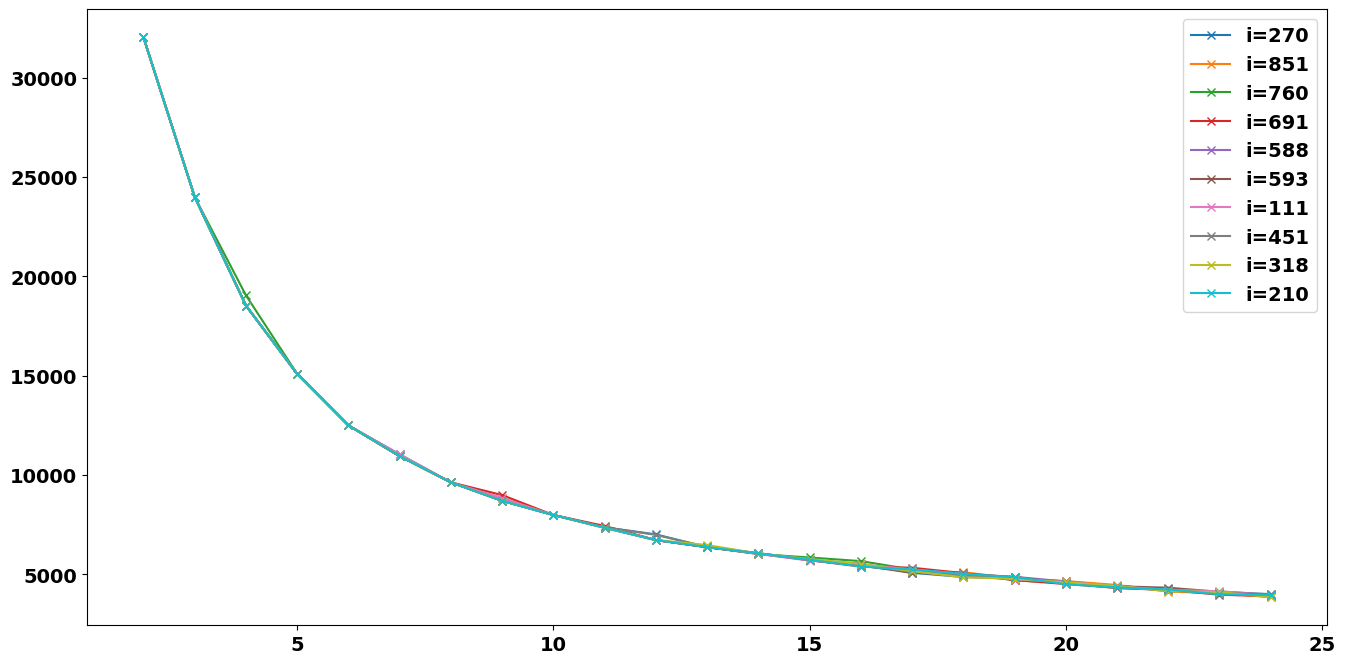

In [18]:
Functions.plot_inertia(scaled_data[fit_variables], 25, 10)

In [19]:
# kmeans_solZ = KMeans(n_clusters=6, random_state=42).fit(scaled_data[fit_variables])
# individuals['cluster_kmeansZ'] =  kmeans_solZ.predict(scaled_data[fit_variables])

In [20]:
# pickle.dump(kmeans_solZ, open('kmeans_solutionz.sav', 'wb'))

In [21]:
solutionz = pickle.load(open('kmeans_solutionz.sav', 'rb'))

In [22]:
individuals['cluster_kmeansZ'] =  solutionz.predict(scaled_data[fit_variables])

<a class="anchor" id="3.2.-bullet">     
    

#### 3.2. Assessing the Results
</a>

In [23]:
individuals_num = individuals.drop(['customer_name', 'region'], axis=1)

> Now let's assess the results using the UMAP and Silhuette method.

##### UMAP

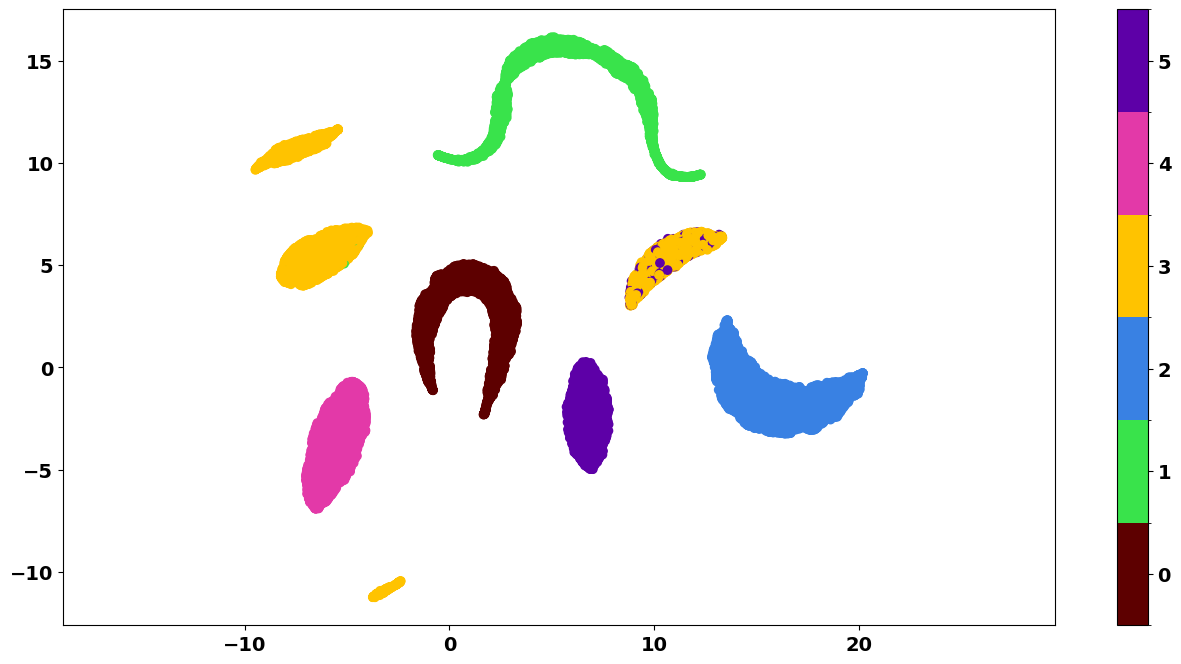

In [24]:
Functions.umap_plot(individuals_num, 'cluster_kmeansZ')

#### Silhouette Method

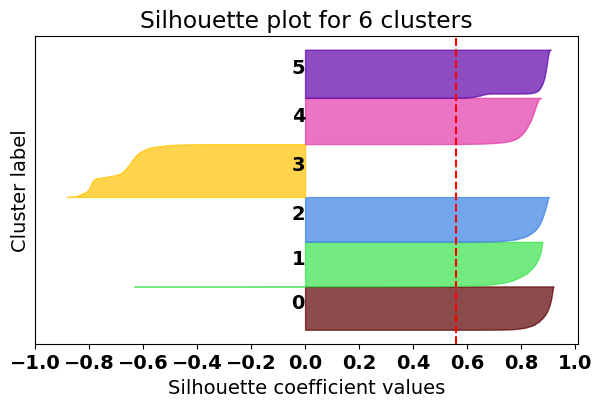

Silhouette score for 6 clusters: 0.5607


In [25]:
Functions.silhoette_method(individuals_num, 'cluster_kmeansZ')

In [26]:
abnormal2= 3
abnormal3 = 5

> It seems that all clusters - with exceptions to cluster 1 - are pretty well defined. A group of observations belonging to cluster 4 appear to fit better on cluster 1. Let's analyze the observations within both these segments to determine what can be done to define them better.

<a class="anchor" id="3.3.-bullet">     
    

#### 3.3. Analyzing the Segments
</a>

In [27]:
Functions.compare_clusters(individuals_num, 'cluster_kmeansZ')

,0,1,2,3,4,5,general_mean
customer_gender,0.494143,0.490188,0.499790,0.499555,0.491567,0.503223,0.496574
kids_home,0.689588,1.158261,0.997901,0.288027,1.000203,2.820473,1.155404
teens_home,0.068547,0.770838,0.271620,0.235901,0.069904,1.651690,0.516827
number_complaints,0.500000,0.311247,1.551008,0.431062,1.010567,0.852901,0.770169
distinct_stores_visited,1.992625,2.000211,7.999580,2.275218,20.001829,3.009181,6.159636
lifetime_spend_groceries,200.406291,996.547373,14993.307935,2543.776908,302.959764,5175.689002,4008.813629
lifetime_spend_electronics,4999.557484,51.534712,199.970403,574.609322,20.000000,270.319008,972.556727
typical_hour,20.951844,9.964760,11.914568,17.074542,8.991668,17.536433,14.461107
lifetime_spend_vegetables,20.033623,1495.731589,799.560034,260.747732,300.231863,584.668881,568.474340
lifetime_spend_nonalcohol_drinks,1500.946855,20.918126,900.786104,300.517346,300.431823,856.516898,633.505206


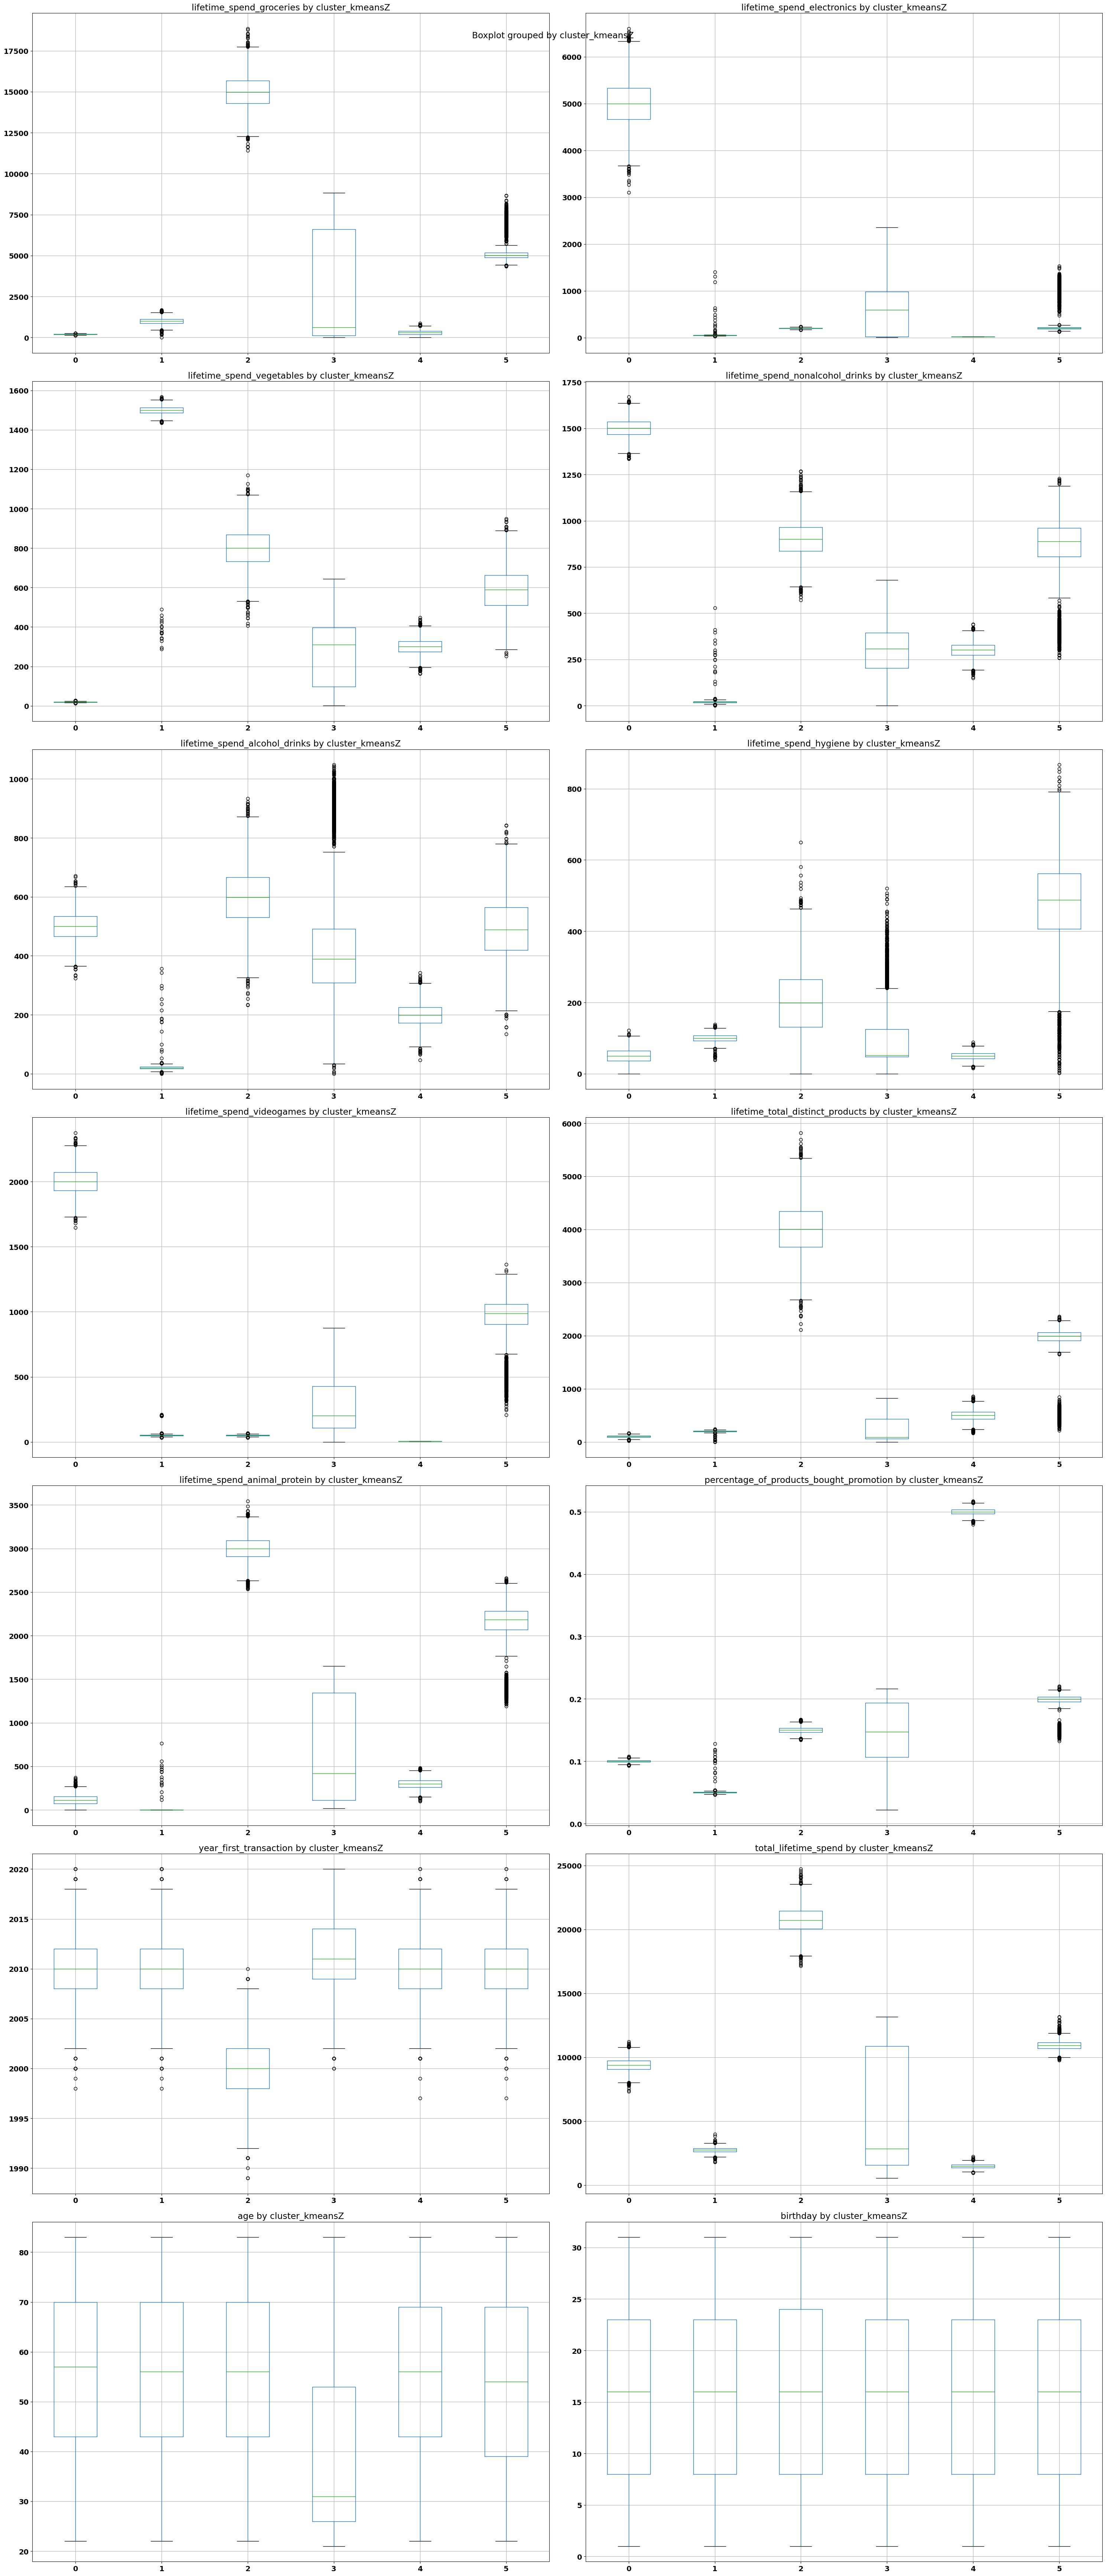

In [28]:
Functions.boxplot_by(individuals, continuous, 'cluster_kmeansZ')

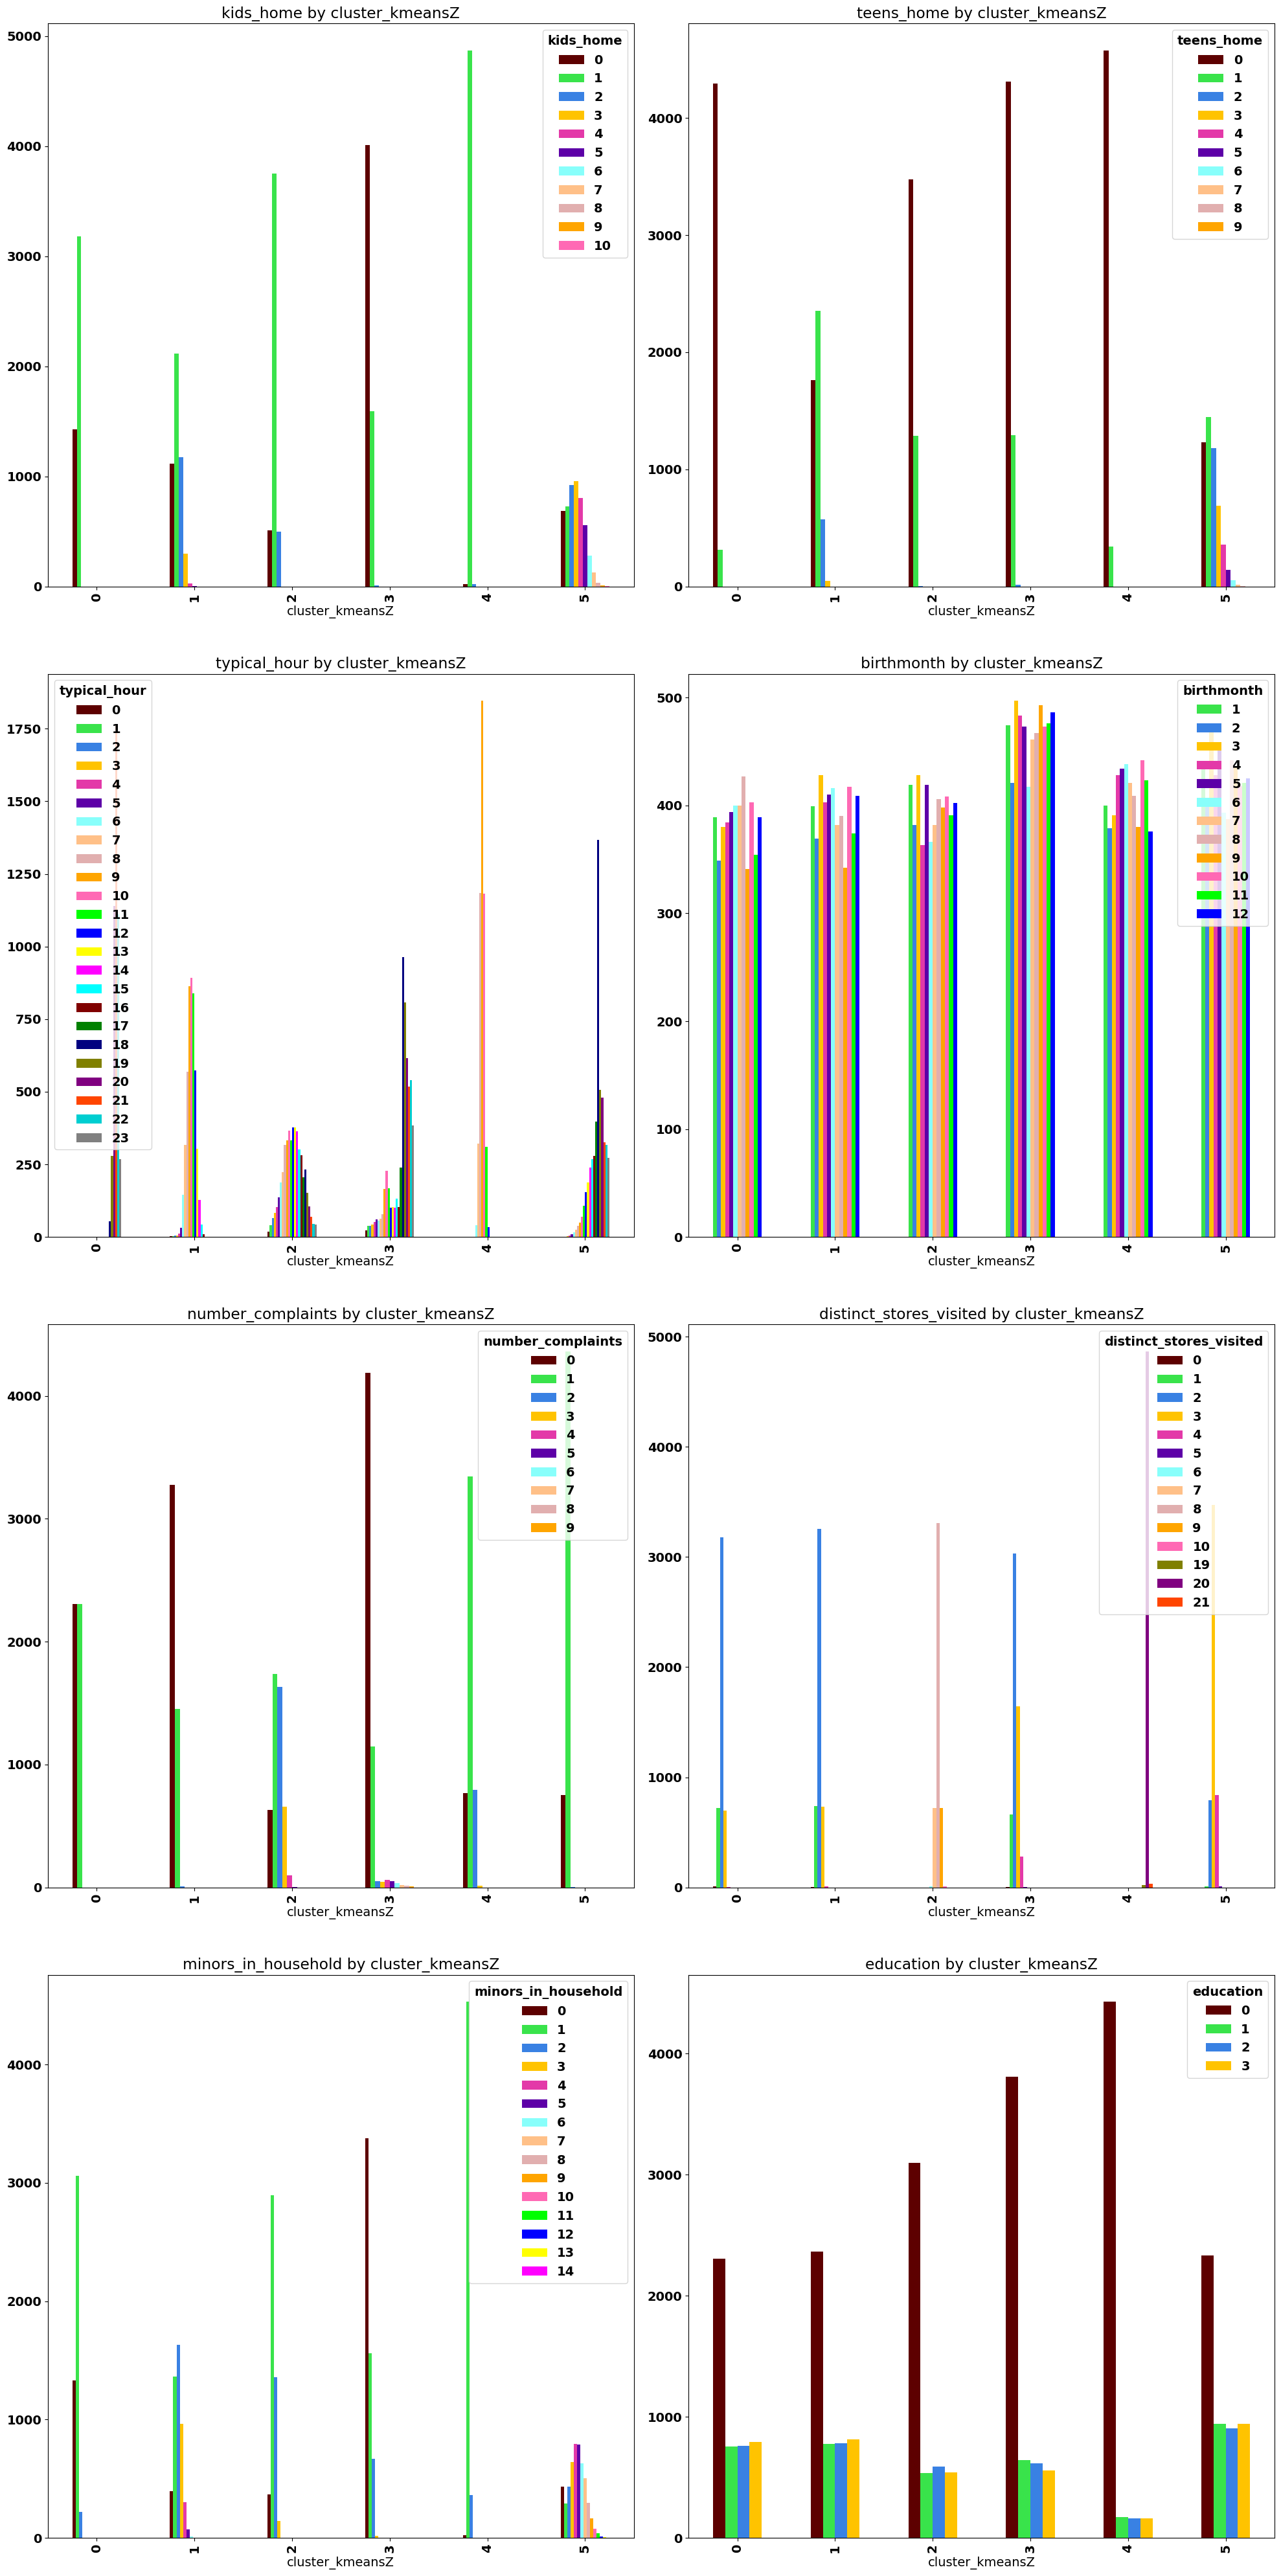

In [29]:
Functions.barplot_by_2(individuals, discrete, 'cluster_kmeansZ')

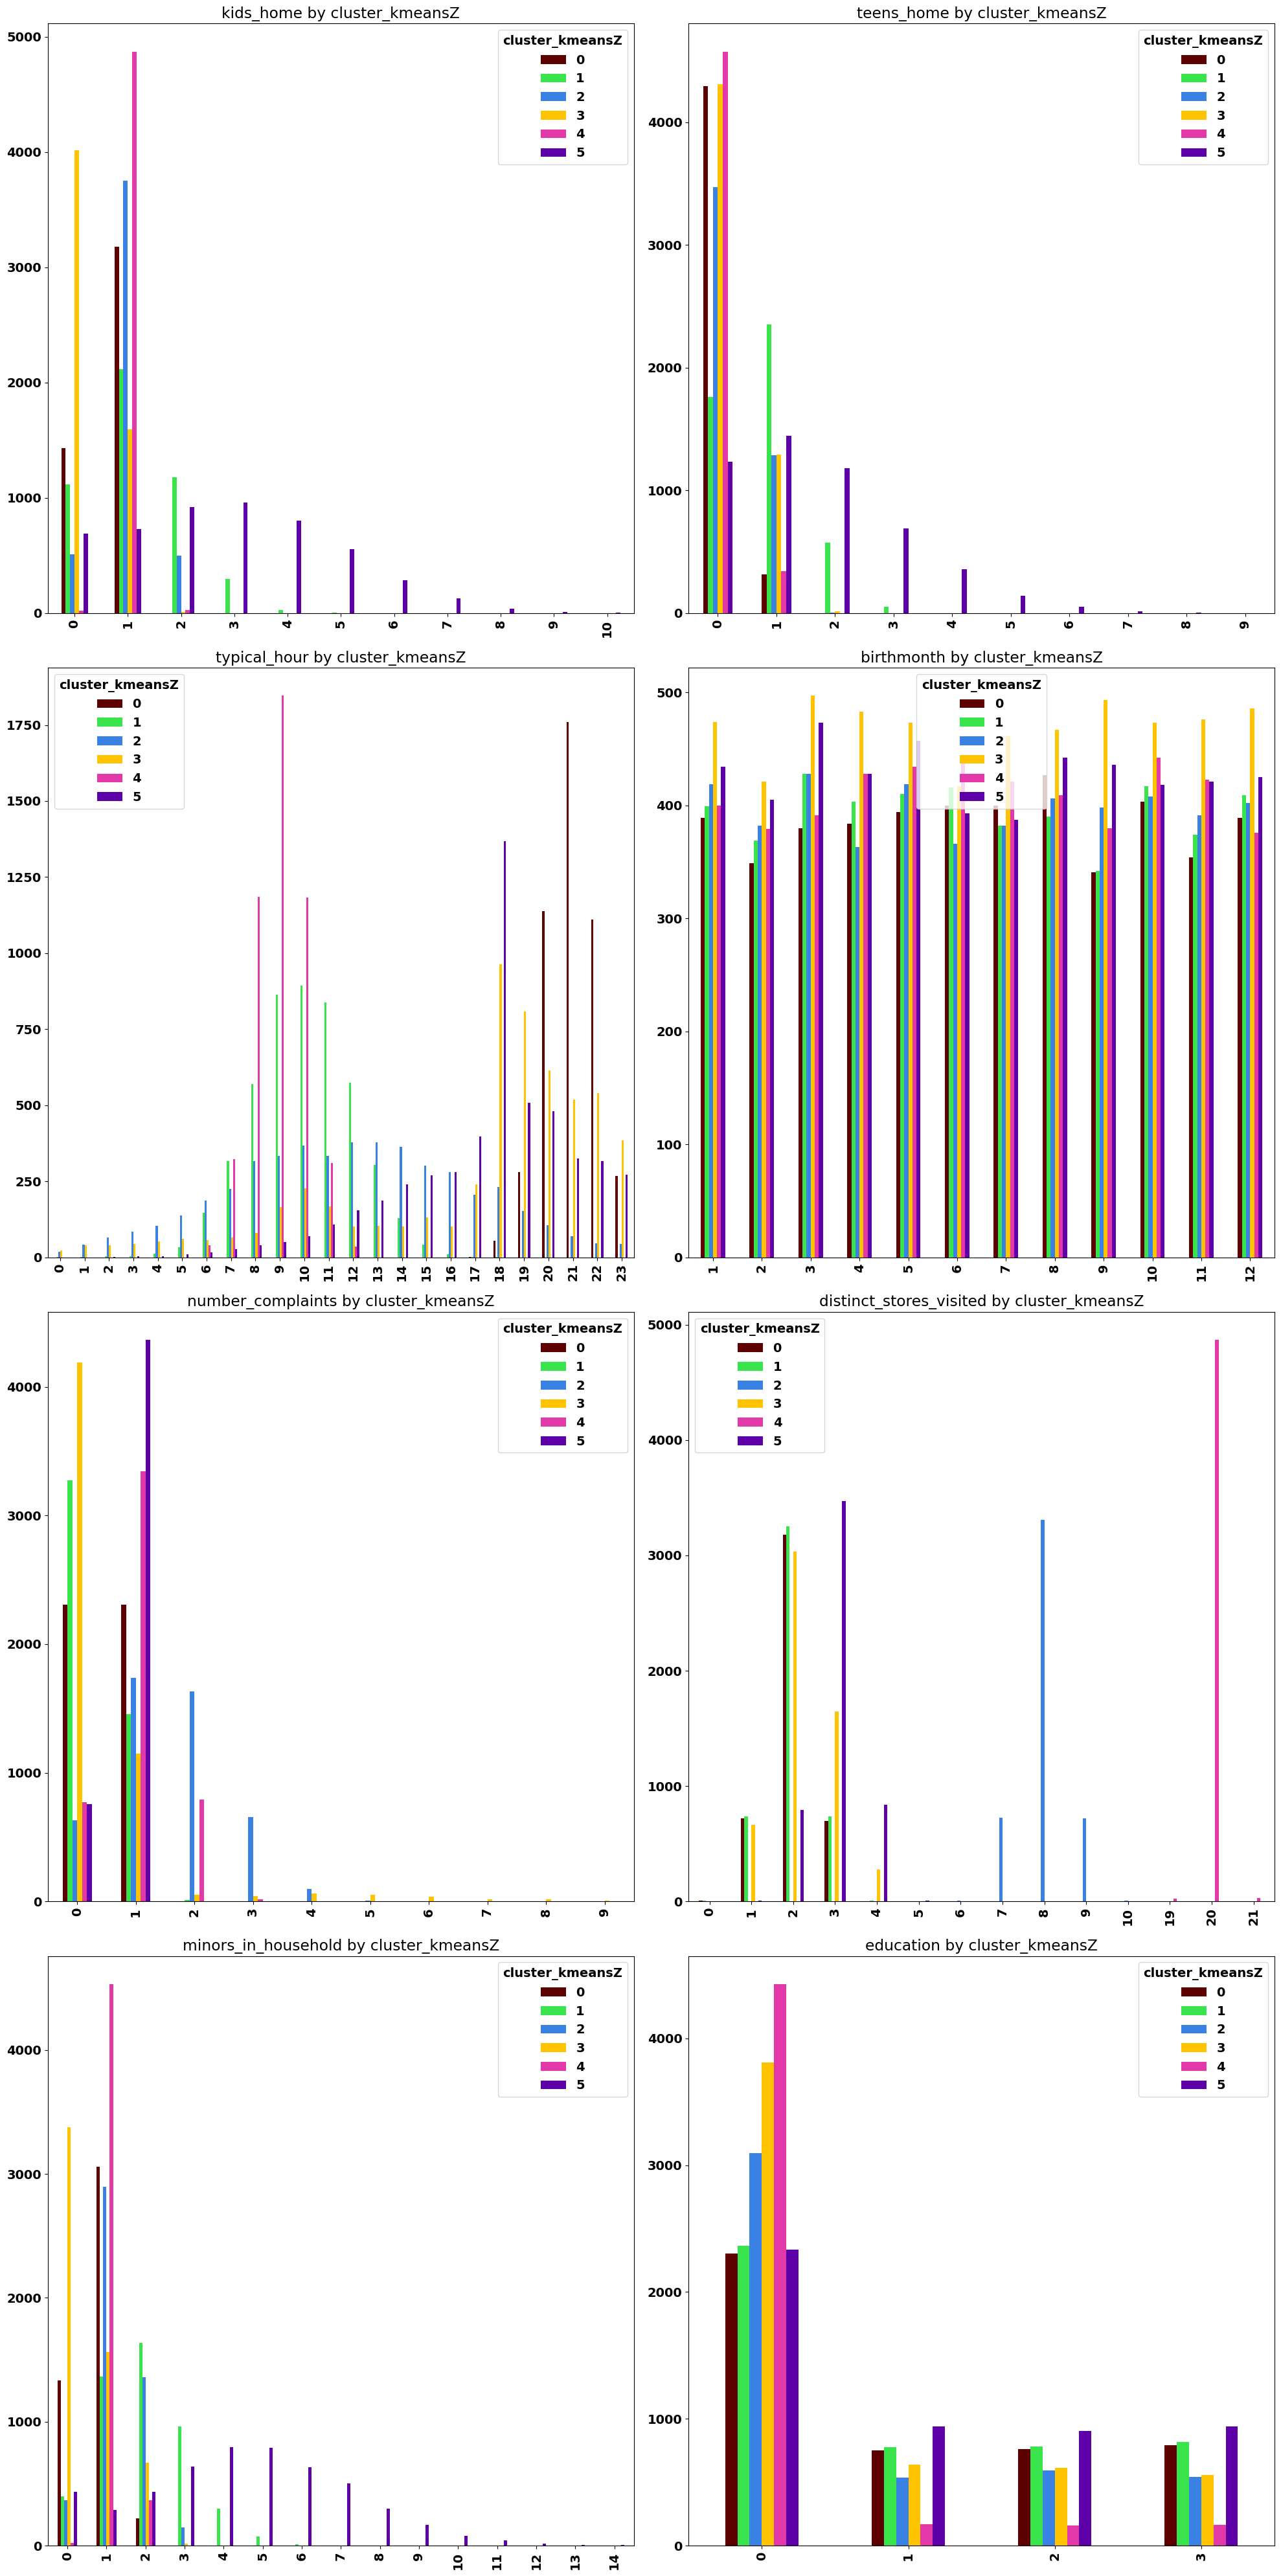

In [30]:
Functions.barplot_by(individuals, discrete, 'cluster_kmeansZ')

In [33]:
columns = list(individuals_num.columns)



In [34]:
columns

['customer_gender',
 'kids_home',
 'teens_home',
 'number_complaints',
 'distinct_stores_visited',
 'lifetime_spend_groceries',
 'lifetime_spend_electronics',
 'typical_hour',
 'lifetime_spend_vegetables',
 'lifetime_spend_nonalcohol_drinks',
 'lifetime_spend_alcohol_drinks',
 'lifetime_spend_meat',
 'lifetime_spend_fish',
 'lifetime_spend_hygiene',
 'lifetime_spend_videogames',
 'lifetime_total_distinct_products',
 'percentage_of_products_bought_promotion',
 'year_first_transaction',
 'loyalty_card',
 'latitude_encoded',
 'longitude_encoded',
 'total_lifetime_spend',
 'minors_in_household',
 'birthday',
 'birthmonth',
 'age',
 'education',
 'lifetime_spend_animal_protein',
 'cluster_kmeansZ']

In [ ]:
Functions.pairplot(individuals, columns, 'cluster_kmeansZ', sampling=1000)

In [ ]:
columns.remove('cluster_kmeansZ')

> The hypothesis that all clusters seem well defined with exceptions to Cluster 1 holds. 

<a class="anchor" id="3.4.-bullet">     
    

#### 3.4. Adjusting the Segments
</a>

> To understand how can this cluster be improved, lets analyze solely the observations from cluster 1 and 4.

In [ ]:
customers_subset = individuals[(individuals['cluster_kmeansZ'] == abnormal2) |( individuals['cluster_kmeansZ'] == abnormal3)]

In [ ]:
Functions.plot_histograms(customers_subset, cols= ['age','lifetime_spend_groceries', 'lifetime_spend_electronics', 'lifetime_spend_vegetables',
                              'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 'lifetime_spend_meat', 'lifetime_spend_fish',
                              'lifetime_spend_hygiene', 'lifetime_spend_videogames', 'lifetime_total_distinct_products',
                              'percentage_of_products_bought_promotion', 'total_lifetime_spend'], hue_var='cluster_kmeansZ')

In [ ]:
Functions.barplot_by(customers_subset, discrete, 'cluster_kmeansZ')

> It seems that there is a particular group that consumes a lot of alcohol. What if we try to separate them from the rest of the observations within this group?

In [ ]:
customers_subset # só os dois clusters anormais

In [ ]:
customers_subset = individuals[(individuals['cluster_alcohol_division'] == 1) | (individuals['cluster_alcohol_division'] == 4)]

In [ ]:
fit_variables0 = ['minors_in_household', 'lifetime_spend_groceries', 'typical_hour',
 'lifetime_spend_vegetables','lifetime_spend_nonalcohol_drinks','lifetime_spend_alcohol_drinks',
 'lifetime_spend_hygiene','lifetime_total_distinct_products','percentage_of_products_bought_promotion',
 'year_first_transaction', 'age', 'total_lifetime_spend',
 'education','lifetime_spend_animal_protein','lifetime_spend_videogames', 'lifetime_spend_electronics']

# testar depois com distinct_stores_visited
# testar sem precentage

In [ ]:
customers_subset_num = customers_subset
scaled_data2 = scaler.fit_transform(customers_subset_num)
scaled_data2 = pd.DataFrame(scaled_data2, index= customers_subset_num.index, columns=customers_subset_num.columns)

> The prior analysis' suggested that there are two clusters within the segment being adjusted, let's experiment with K-Means once again on this group of observations.

In [ ]:
subcluster_k2 = KMeans(n_clusters=2, random_state=0).fit(scaled_data2[fit_variables0])
pickle.dump(subcluster_k2, open('subcluster_k2.sav', 'wb'))

In [ ]:
subcluster_k2 = pickle.load(open('subcluster_k2.sav', 'rb'))
customers_subset['cluster_kmeans2'] =  subcluster_k2.predict(scaled_data2[fit_variables0])

In [ ]:
Functions.umap_plot(customers_subset.drop(['region', 'customer_name'], axis=1), 'cluster_kmeans2')

In [ ]:
Functions.silhoette_method(customers_subset.drop(['region', 'customer_name'], axis=1), 'cluster_kmeans2')

In [ ]:
Functions.plot_histograms(customers_subset.drop(['region', 'customer_name'], axis=1), ['age','lifetime_spend_groceries', 'lifetime_spend_electronics', 'lifetime_spend_vegetables',
                              'lifetime_spend_nonalcohol_drinks', 'lifetime_spend_alcohol_drinks', 'lifetime_spend_meat', 'lifetime_spend_fish',
                              'lifetime_spend_hygiene', 'lifetime_spend_videogames', 'lifetime_total_distinct_products',
                              'percentage_of_products_bought_promotion', 'total_lifetime_spend'], 'cluster_kmeans2')

In [ ]:
customers_subset.replace({'cluster_kmeans2': {1: 4, 0:1}}, inplace=True)

In [ ]:
individuals = individuals.join(customers_subset['cluster_kmeans2'], on='customer_id')

In [ ]:
individuals['segment'] = np.where(individuals['cluster_kmeans2'].isnull() == True, individuals['cluster_alcohol_division'], individuals['cluster_kmeans2'])

In [ ]:
individuals.drop([ 'cluster_kmeansZ',  'cluster_alcohol_division', 'cluster_kmeans2'], axis=1, inplace=True)

In [ ]:
Functions.integer_convert(individuals, ['segment'])

In [ ]:
Functions.umap_plot(individuals.drop(['customer_name', 'region'], axis=1), 'segment')

<br>

---
<br>

<a class="anchor" id="4.-bullet">     
    

### 4. Profilling - Final Interpretation of the Segments

</a>

In [ ]:
Functions.compare_clusters(individuals.drop(['birthday', 'customer_gender', 'birthmonth', 'lifetime_spend_meat', 'lifetime_spend_fish', 'latitude_encoded', 'longitude_encoded'], axis=1), ['segment'])

In [ ]:
Functions.plot_bar_charts(individuals, ['segment'])

In [ ]:
8Functions.boxplot_by(individuals, continuous, 'segment')

In [ ]:
individuals[individuals['segment'] == 6]['region']


In [ ]:
Functions.barplot_by_2(individuals, discrete, 'segment')

In [ ]:
Functions.barplot_by(individuals, discrete, 'segment')

In [ ]:
columns.append('segment')

In [ ]:
individuals.columns

In [ ]:
columns

In [ ]:
Functions.pairplot(individuals, columns, 'segment')

> Exporting the customer data with all segments

In [ ]:
supermarkets = pd.read_csv('supermarkets preprocessed.csv')
supermarkets['segment'] = 7
supermarkets.set_index('customer_id', inplace=True)
customers = pd.concat([individuals, supermarkets], axis=0)
customers.to_csv('customers_clustered.csv', index=True)